### STA analysis in Python

*What is an STA?* Simply, a spike-triggered average is the average of some variable taken around the spike times of a single neuron. There are lots of mathematical and conceptual details that we're not interested in right now. Crucially, this is an analysis that is fairly common in neuroscience, especially visual neuroscience (particularly for modeling receptive fields), so it's likely that you'll encounter it at some point if you haven't already. Here, I'll show you how to perform it in Python. 

*In the lab...*
After we were able to conclusively show that neurons exhibit sharp electrical impulses that we term "spikes," our next grant application was successful. However, it was a small grant, so all we were able to do was buy a flashlight. With this new equipment, we did the same experiment as before but this time we flashed our light on and off randomly while recording from one of these visually sensitive neurons. 

#### 1D STA

In [95]:
import numpy as np
import scipy.io as sio # try loading .mat file in way loaded previous file first

flash_data = sio.loadmat('flashlight_data.mat')
print flash_data

{'stimulus': array([[ 1.,  1., -1., ...,  1.,  1.,  1.]]), '__version__': '1.0', '__header__': 'MATLAB 5.0 MAT-file Platform: posix, Created on: Tue Mar  8 15:55:47 2016', 'spiketimes': array([[    60,     64,     93, ..., 999981, 999992, 999993]]), '__globals__': []}


In [96]:
# the new_data variable is a new type: dictionaries, they are similar to matlab's structure type
# so let's access these "fields"

# new_data.stimulus # in python, we reference the fields of dictionaries by [<fieldname>]
stim = flash_data['stimulus'].T[:, 0] # add .T after someone notices it, make point about len() or iteration
spks = flash_data['spiketimes'].T[:, 0]

# we read online somewhere that the stimulus for this sort of thing should have zero mean
print 'stimulus mean: {}'.format(np.mean(stim))
print 'stimulus shape: {}'.format(stim.shape)
print 'number of spikes: {}'.format(spks.shape)

stimulus mean: 0.001282
stimulus shape: (1000000,)
number of spikes: (57754,)


In [97]:
# close enough; looks like we've got quite a bit of data

# what's the firing rate of this neuron? (plot PSTH with function from previous part)
print 'firing rate: {}Hz'.format(1000*len(spks)/float(len(stim)))

# what else do we want to know? ISI distribution? Fano factor? CV? 

firing rate: 57.754Hz


In [100]:
# so how should we go about finding the spike-triggered average?

#what arguments should it take? What should it return? 
def get_sta(spks, stim, prespk=100, postspk=10):
    all_regions = np.zeros((len(spks), prespk + postspk))
    for i, s in enumerate(spks): # iterate directly through spks, through inds, or using enumerate?
        # for each spike, we want to pull out some region of stimulus around them? 
        # where should we specify the size of that region? default params
        if s >= prespk and s < len(stim) - postspk:
            stim_region = stim[s-prespk:s+postspk] # where should I put this?
            all_regions[i, :] = stim_region
        else:
            all_regions[i, :] = np.nan
    sta = np.nanmean(all_regions, axis=0) # axis of application
    return sta
    
# debug ValueError, put print statement for s...
# add if -- but what about the unused indices? replace with nan, use nanmean
# this extra dimension is just annoying, let's get rid of it! 
prespk = 100
postspk = 10

sta = get_sta(spks, stim, prespk=prespk, postspk=postspk)

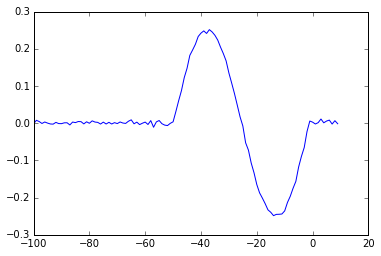

In [101]:
# well, this looks reasonable, but how can we get a better view?
import matplotlib.pyplot as plt
%matplotlib inline  

# what do we want to give to this function? 
def plot_sta(sta, prespk, postspk):
    ts = np.arange(-prespk, postspk, 1)
    f = plt.figure()
    ax = f.add_subplot(1,1,1)
    ax.plot(ts, sta)
    plt.show()
    
plot_sta(sta, prespk, postspk)

Now that we have a filter that describes the neuron's response, we notice that it looks suspiciously like a sine wave. Let's try to find a more compact description of this neuron's response. By obtaining that description, we can then characterize how similar (or not) response properties of a populations of neurons are.

[  0.13346146   0.25036224   0.12853857 -49.99999977  -1.        ]


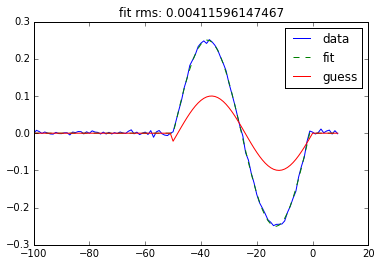

In [156]:
import scipy.optimize as spo

def fitting_sine(x, a, b, c, lb, rb):
    y = b*np.sin(c*x + a)
    y[x > rb] = 0
    y[x < lb] = 0
    return y

xs = np.arange(-prespk, postspk)
guess_params = (0, .1, .13, -50, -1)
params, _ = spo.curve_fit(fitting_sine, xs, sta, guess_params)
print params
f = plt.figure()
ax = f.add_subplot(1, 1, 1)
ax.plot(xs, sta, label='data')
fit_sta = fitting_sine(xs, *params)
frms = np.sqrt(np.mean((fit_sta - sta)**2))
ax.plot(xs, fit_sta, '--', label='fit')
guess_sta = fitting_sine(xs, *guess_params)
ax.plot(xs, guess_sta, label='guess')
ax.set_title('fit rms: {}'.format(frms))
ax.legend()

#### 2D STA

Because we were able to compellingly show that neurons have a complex dependence on simple stimuli, we were able to get another grant. This time, we used the money to buy one hundred flashlights, which we tiled into a ten by ten grid -- then we used the rest of the money to hire undergraduates to turn the flashlights on and off in a random pattern. In this way, we can test the neuron's spatial and temporal dependence on the stimulus. 

In [103]:
mon_data = sio.loadmat('monitor_data_int.mat')
spks_2d = mon_data['spiketimes'][0, :]
stim_2d = mon_data['stimulus']

print stim.shape
print spks.shape

(1000000,)
(57754,)


In [104]:

def get_2d_sta(spks, stim, prespk=70, postspk=10):
    all_regions = np.zeros((len(spks), prespk + postspk)+(stim.shape[-2:]))
    for i, s in enumerate(spks): # iterate directly through spks, through inds, or using enumerate?
        # for each spike, we want to pull out some region of stimulus around them? 
        # where should we specify the size of that region? default params
        if s >= prespk and s < len(stim) - postspk:
            stim_region = stim[s-prespk:s+postspk, :, :] # where should I put this?
            all_regions[i, :, :, :] = stim_region
        else:
            all_regions[i, :, :, :] = np.nan
    sta = np.nanmean(all_regions, axis=0) # axis of application
    return sta

stapre_2d = 70
stapost_2d = 20

sta_2d = get_2d_sta(spks_2d, stim_2d, prespk=stapre_2d, postspk=stapost_2d)

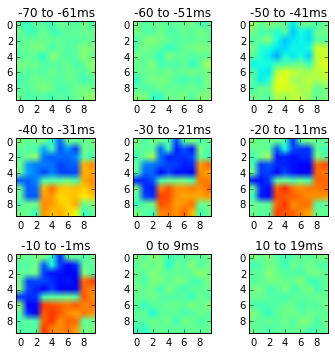

In [105]:
def plot_2d_sta(sta, stapre, stapost, n_ts=9., figsize=(5, 5)):
    f = plt.figure(figsize=figsize)
    slices_t = np.floor(sta.shape[0]/float(n_ts))
    n = np.ceil(np.sqrt(n_ts))
    allmin = np.min(sta)
    allmax = np.max(sta)
    ts = np.arange(-stapre, stapost)
    for i in xrange(int(n_ts)):
        sli = np.mean(sta[i*slices_t:(i+1)*slices_t], 0)
        ax = f.add_subplot(n, n, i+1)
        ax.imshow(sli, vmin=allmin, vmax=allmax)
        t0, t1 = ts[i*slices_t], ts[(i+1)*slices_t - 1]
        ax.set_title('{} to {}ms'.format(t0, t1))
    f.tight_layout()
    plt.show()

plot_2d_sta(sta_2d, stapre_2d, stapost_2d, n_ts=9.)

In [115]:
# Can we write a function that gracefully deals with both 1D and 2D STAs?
def get_nd_sta(spks, stim, prespk=70, postspk=10):
    all_regions = np.zeros((len(spks), prespk + postspk)+(stim.shape[1:]))
    for i, s in enumerate(spks): # iterate directly through spks, through inds, or using enumerate?
        # for each spike, we want to pull out some region of stimulus around them? 
        # where should we specify the size of that region? default params
        if s >= prespk and s < len(stim) - postspk:
            stim_region = stim[s-prespk:s+postspk] # where should I put this?
            all_regions[i] = stim_region
        else:
            all_regions[i] = np.nan
    sta = np.nanmean(all_regions, axis=0) # axis of application
    return sta

sta_2d = get_nd_sta(spks_2d, stim_2d, prespk=stapre_2d, postspk=stapost_2d)
sta_1d = get_nd_sta(spks, stim, prespk=stapre, postspk=stapost)

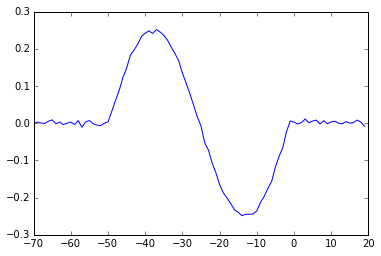

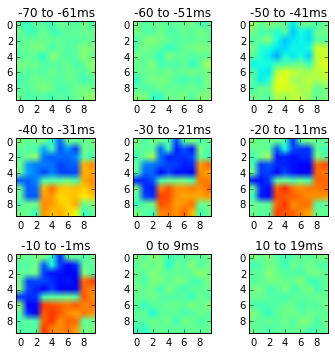

In [116]:
plot_sta(sta_1d, stapre, stapost)
plot_2d_sta(sta_2d, stapre_2d, stapost_2d)

So, this works, but it can take a little while to run -- and this stimulus isn't very large (only 10x10 pixels). We could run into issues with scaling; is there a way we can make it run a little faster? 

+ *reduce space complexity:* we could do this by keeping a running average instead of populating a large array; most modern computers have plenty of memory, however, so this isn't much of a concern -- it probably won't save us any real time

+ *reduce time complexity:* it's not obvious to me personally that the time complexity of these operations can actually be reduced, we'll always need to look at the stimulus region around every spike -- we can potentially increase speed by being more careful about our operations inside the for-loop, but such optimizations often make out code more confusing without having a large effect on runtime (and only changing the constant factor of the time complexity)

+ *increase execution speed (__vectorize__):* often times, once the obvious time and space optimizations have been performed, the largest performance gains will come from vectorizing operations over large arrays; this is similar to MatLab in the sense that many numpy and scipy functions are written in a compiled language, such as C++, that has faster execution times than interpreted languages (eg, MatLab and Python); so, is it possible to vectorize all or part of this function? Yes, yes it is. But is it faster? Uh, maybe not...

In [117]:
import numpy.lib.stride_tricks as npst # show from ... import ... form

def get_nd_sta_vectorized(spks, stim, prespk=70, postspk=10):
    nan_buff_pre = np.empty((prespk,)+stim.shape[1:])
    nan_buff_pre[:] = np.nan
    nan_buff_post = np.empty((postspk+1,)+stim.shape[1:])
    nan_buff_post[:] = np.nan
    buff_stim = np.concatenate((nan_buff_pre, stim, nan_buff_post), axis=0)
    stri_shape = (stim.shape[0], prespk+postspk)+stim.shape[1:]
    elsize = stim.itemsize
    dimlist = [0] + range(len(stim.shape))
    stride_size = [elsize*np.prod((stim.shape+(1,))[i+1:]) for i in dimlist]
    strided_stim = npst.as_strided(buff_stim, shape=stri_shape, strides=stride_size)
    sta = np.nanmean(strided_stim[spks], axis=0)
    return sta

sta_2d_v = get_nd_sta_vectorized(spks_2d, stim_2d, prespk=stapre_2d, postspk=stapost_2d)
sta_1d_v = get_nd_sta_vectorized(spks, stim, prespk=stapre, postspk=stapost)

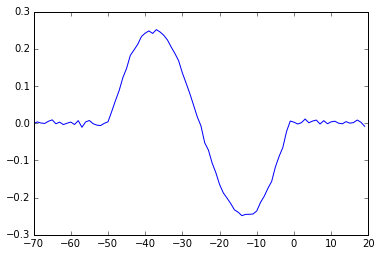

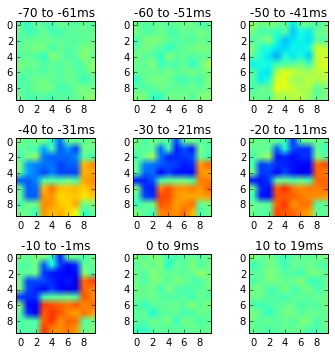

In [118]:
plot_sta(sta_1d_v, stapre, stapost)
plot_2d_sta(sta_2d_v, stapre_2d, stapost_2d)

In [119]:
%timeit sta_2d_v = get_nd_sta_vectorized(spks_2d, stim_2d, prespk=stapre_2d, postspk=stapost_2d)
%timeit sta_2d = get_nd_sta(spks_2d, stim_2d, prespk=stapre_2d, postspk=stapost_2d)

1 loops, best of 3: 6.8 s per loop
1 loops, best of 3: 7 s per loop
